In [1]:
import pandas as pd
import numpy as np
import random
import csv
from prettytable import PrettyTable
from pylab import *
from scipy.stats import wasserstein_distance
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [2]:
###Change the data file directory below appropriately
data = pd.read_csv('../raw_data/0A986513-7828-4D53-AA1F-E02D6DF9561B.features_labels.csv')
#data = pd.read_csv('../aggregated_data/aggregated_data.csv')
data.head()

,timestamp,raw_acc:magnitude_stats:mean,raw_acc:magnitude_stats:std,raw_acc:magnitude_stats:moment3,raw_acc:magnitude_stats:moment4,raw_acc:magnitude_stats:percentile25,raw_acc:magnitude_stats:percentile50,raw_acc:magnitude_stats:percentile75,raw_acc:magnitude_stats:value_entropy,raw_acc:magnitude_stats:time_entropy,...,label:STAIRS_-_GOING_DOWN,label:ELEVATOR,label:OR_standing,label:AT_SCHOOL,label:PHONE_IN_HAND,label:PHONE_IN_BAG,label:PHONE_ON_TABLE,label:WITH_CO-WORKERS,label:WITH_FRIENDS,label_source
0,1449601597,1.000371,0.007671,-0.016173,0.027860,0.998221,1.000739,1.003265,0.891038,6.684582,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
1,1449601657,1.000243,0.003782,-0.002713,0.007046,0.998463,1.000373,1.002088,1.647929,6.684605,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
2,1449601717,1.000811,0.002082,-0.001922,0.003575,0.999653,1.000928,1.002032,1.960286,6.684610,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
3,1449601777,1.001245,0.004715,-0.002895,0.008881,0.999188,1.001425,1.003500,1.614524,6.684601,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
4,1449601855,1.001354,0.065186,-0.096520,0.165298,1.000807,1.002259,1.003631,0.837790,6.682252,...,0.0,NaN,0.0,1.0,NaN,NaN,NaN,NaN,0.0,2


# Interpolating columns with average values

In [3]:
def interpolation(df):
    col_to_avg = list(df.columns) #Start with keeping all the columns as columns to use an average interpolation on
    for k in range(len(list(df.columns))):
        if list(df.columns)[k].startswith(('discrete', 'label')): #Remove label and discrete columns from col_to_avg
            col_to_avg.remove(list(df.columns)[k])
    
    df_with_avg = df[col_to_avg].fillna(df[col_to_avg].mean()) #Interpolate nan columns for all continuous-valued columns with average
    
    col_to_zero = list(df.columns)
    for k in range(len(list(df.columns))):
        if not list(df.columns)[k].startswith(('discrete', 'label')): #Remove all columns except label and discrete
            col_to_zero.remove(list(df.columns)[k])
    
    df_with_zero = df[col_to_zero].fillna(0) #Interpolate nan values for label and discrete columns with 0
    
    return pd.concat([df_with_avg, df_with_zero], axis = 1)

# Splitting the data and loading it into a PyTorch dataloader

In [4]:
X = data.iloc[:,1:27]
y = data[['label:SITTING']]

X = X[y['label:SITTING'] == 1]
y = y[y['label:SITTING'] == 1]

X = interpolation(X).values
y = interpolation(y).values

print(len(X), len(y))

2253 2253


In [5]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(X)
#X

# Helper Functions for Training

In [6]:
def generator_block(input_dim, output_dim):
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.Dropout(0.1),
        nn.BatchNorm1d(output_dim),
        nn.ReLU(inplace = True)
    )
def get_noise(n_samples, z_dim):
    return torch.randn(n_samples, z_dim)

class Generator(nn.Module):
    def __init__(self, z_dim = 10, feature_dim = 26, hidden_dim = 128):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
             generator_block(z_dim, 80),
            generator_block(80, 60),
            generator_block(60, 40),
            generator_block(40, 28),
            nn.Linear(28, feature_dim)
        )
    def forward(self, noise):
        return self.gen(noise)

def discriminator_block(input_dim, output_dim):
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.Dropout(0.1),
        nn.LeakyReLU(0.05)
    )

class Discriminator(nn.Module):
    def __init__(self, feature_dim = 26, hidden_dim = 16):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            discriminator_block(feature_dim, hidden_dim),
            discriminator_block(hidden_dim, int(hidden_dim/2)),
            discriminator_block(int(hidden_dim/2), int(hidden_dim/4)),
            nn.Linear(int(hidden_dim/4), 1),
            nn.Sigmoid()                    
        )
    def forward(self, feature_vector):
        return self.disc(feature_vector)

def get_disc_loss(gen, disc, criterion, real_features, batch_size, z_dim):
    latent_vectors = get_noise(batch_size, z_dim)
    fake_features = gen(latent_vectors)
    pred_fake = disc(fake_features.detach())
    
    ground_truth = torch.zeros_like(pred_fake)
    loss_fake = criterion(pred_fake, ground_truth)
    
    pred_real = disc(real_features)
    ground_truth = torch.ones_like(pred_real)
    loss_real = criterion(pred_real, ground_truth)
    
    disc_loss = (loss_fake + loss_real) / 2
    return disc_loss

def get_gen_loss(gen, disc, criterion, batch_size, z_dim):
    latent_vectors = get_noise(batch_size, z_dim)
    fake_features = gen(latent_vectors)
    pred = disc(fake_features)
    gen_loss = criterion(pred, torch.ones_like(pred))
    return gen_loss

def visualize_gen_batch(gen, b_size, epochs = -1):
    #print(str(b_size))
    latent_vectors = get_noise(b_size, z_dim)
    #print(latent_vectors.shape)
    fake_features = gen(latent_vectors)
    #print(fake_features.shape)
    
    w_img = fake_features
    wmin = torch.min(w_img)
    wmax = torch.max(w_img)
    w_img = w_img.cpu()
    w_img = w_img.detach().numpy()
    c = plt.imshow(w_img, cmap ='Reds', vmin = wmin , vmax = wmax,
                        interpolation ='nearest', origin ='upper')
    plt.colorbar(c)
    plt.title('Generated Batch at Epoch ' + str(epochs), fontweight ="bold")
    plt.show()
    
def visualize_real_batch(features):
    w_img = features
    wmin = torch.min(w_img)
    wmax = torch.max(w_img)
    w_img = w_img.cpu()
    w_img = w_img.detach().numpy()
    c = plt.imshow(w_img, cmap ='Reds', vmin = wmin , vmax = wmax,
                        interpolation ='nearest', origin ='upper')
    plt.colorbar(c)
    plt.title('Real Batch of Data', fontweight ="bold")
    plt.show()
    
def performance_stats(gen, disc, b_size, batch = None):
    tp = 0
    fp = 0
    tn = 0
    fn = 0

    with torch.no_grad():
        if batch is None:
            latent_vectors = get_noise(b_size, z_dim)
            fake_features = gen(latent_vectors)
            y_hat = torch.round(disc(fake_features))
            y_label = [0] * b_size
            y_label = torch.Tensor(y_label)
        else:
            latent_vectors = get_noise(int(b_size/2), z_dim)
            fake_features = gen(latent_vectors)
            y_hat = torch.round(disc(fake_features))
            y_label = [0] * int(b_size/2)
            
            real_y_hat = torch.round(disc(batch[:int(b_size/2)]))
            for i in range(0, int(b_size/2)):
                y_label.append(1)
            y_hat = torch.cat((y_hat, real_y_hat), dim = 0)
            
            #print(y_hat)
            #print(y_label)
         
        
        for k in range(len(y_hat)):
            #True positive
            if y_label[k] == 1 and y_hat[k] == 1:
                tp += 1
            #False Negative
            elif y_label[k] == 1 and y_hat[k] == 0:
                fn += 1
            #True Negative
            elif y_label[k] == 0 and y_hat[k] == 0:
                tn += 1
            elif y_label[k] == 0 and y_hat[k] == 1:
                fp += 1
            else:
                print("Error")
                exit()
            
        class_acc = (tp + tn)/(tp + tn + fp + fn)
        
        if tp + fp == 0:
            precision = 0
        else:
            precision = tp / (tp + fp)
            
        if tp + fn == 0:
            recall = 0
        else:
            recall = tp / (tp + fn)
            
        if fp + tn == 0:
            fpR = 0
        else: 
            fpR = fp / (fp + tn)

        #print(f'Classification Accuracy: {class_acc:.2f}')
        #print(f'Precision: {precision:.2f}') #What percentage of a model's positive predictions were actually positive
        #print(f'Recall: {recall:.2f}') #What percent of the true positives were identified
        #print(f'F-1 Score: {2*(precision * recall / (precision + recall + 0.001)):.2f}')
        return class_acc, precision, recall, fpR, 2*(precision * recall / (precision + recall + 0.0001))
    
    
def density_curves(reals, fakes):
    plt.figure(figsize = (15, 15))
    subplot(2, 2, 1)
    sns.kdeplot(fakes.numpy()[:,0], color = 'r', shade = True, label = 'Fake Distribution')
    sns.kdeplot(reals[:,0], color = 'b', shade = True, label = 'Real Distribution')
    plt.xlabel('Mean Acceleration')
    plt.ylabel('Density')
    plt.legend()
    #plt.show()

    subplot(2, 2, 2)
    sns.kdeplot(fakes.numpy()[:,18], color = 'r', shade = True, label = 'Fake Distribution')
    sns.kdeplot(reals[:,18], color = 'b', shade = True, label = 'Real Distribution')
    plt.xlabel('Mean X-Acceleration')
    plt.ylabel('Density')
    plt.legend()
    #plt.show()

    subplot(2, 2, 3)
    sns.kdeplot(fakes.numpy()[:,19], color = 'r', shade = True, label = 'Fake Distribution')
    sns.kdeplot(reals[:,19], color = 'b', shade = True, label = 'Real Distribution')
    plt.xlabel('Mean Y-Acceleration')
    plt.ylabel('Density')
    plt.legend()
    #plt.show()

    subplot(2, 2, 4)
    sns.kdeplot(fakes.numpy()[:,20], color = 'r', shade = True, label = 'Fake Distribution')
    sns.kdeplot(reals[:,20], color = 'b', shade = True, label = 'Real Distribution')
    plt.xlabel('Mean Z-Acceleration')
    plt.ylabel('Density')
    plt.legend()
    plt.show()
    
def get_fake_samples(gen, batch_size, z_dim):
    """
    Generates fake acceleration features given a batch size, latent vector dimension, and trained generator.
    
    """
    latent_vectors = get_noise(batch_size, z_dim) ### Retrieves a 2D tensor of noise
    fake_features = gen(latent_vectors)
    
    return fake_features ### Returns a 2D tensor of fake features of size batch_size x z_dim

def all_Wasserstein_dists(gen, z_dim, feature_dim, sample):
    wasser_dim = []
    latent_vectors = get_noise(len(sample), z_dim)
    fake_features = gen(latent_vectors)
    for k in range(feature_dim):
        wasser_dim.append(wasserstein_distance(fake_features[:, k].detach().numpy(), sample[:, k].detach().numpy()))
    return torch.tensor(wasser_dim)

# Model Hyperparameters (Always Run Again Before Starting Training Loop) 

In [7]:
# Loss function for model
criterion = nn.BCELoss()

#GAN Name (used for saving model and its output)
gan_id = "1k_5_2_constant_GAN"

# Digit Precision for printouts
dig = 5

# Max epochs to run
n_epochs = 1000

# Number of dimensions of output from generator
feature_dim = 26

# Number of dimensions of latent vector
z_dim = 100

# Batch Size
batch_size = 200

# Learning Rates for Generator (Gen) and Discriminator (Disc)
gen_lr =  0.0001
disc_lr = 0.0001

# Constant epochs approach to train Discriminator, Generator
constant_train_flag = False # Set to true to train based on constant # of epochs per machine 
                            # Set to false to train dynamically based on machine performance
disc_epochs = 5             # Number of consecutive epochs to train discriminator before epoch threshold
gen_epochs = 2              # Number of consecutive epochs to train generator before epoch threshold
epoch_threshold = 28        # Epoch number to change training epoch ratio
disc_epochs_change = 5      # New number of consecutive epochs to train discriminator
gen_epochs_change = 2      # New number of consecutive epochs to train generator
rel_epochs = 0              # Epochs passed since last switch (always set to 0)


# Dynamic number of epochs to train Discriminator, Generator
static_threshold = 28   # Epoch number to change from static ratio to dynamic
static_disc_epochs = 5  # Number of consecutive epochs to train discriminator before epoch threshold
static_gen_epochs = 2   # Number of consecutive epochs to train generator before epoch threshold
pull_threshold = 0.2    # Accuracy threshold for switching machine training when the generator is no longer competitive
push_threshold = 0.8    # Accuracy threshold for switching machine training when the discriminator is no longer competitive
recall_threshold = 0.80

# Which machine to train (0 for Generator, 1 for Discriminator) !!!(do not change unless for good reason)!!!
GENERATOR = 0
DISCRIMINATOR = 1
to_train = DISCRIMINATOR
train_string = "DISC"

# Show model performance per batch (will always show summary for each epoch)
print_batches = False

# Moving corpus data into a pyTorch format !!!(do not change unless for good reason)!!!
train_features = torch.tensor(X)
train_labels = torch.tensor(y)
train_data = torch.utils.data.TensorDataset(train_features, train_labels)
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, shuffle = True)

# Initializiing the Machines !!!(do not change unless for good reason)!!!
disc = Discriminator()
gen = Generator(z_dim)
opt_disc = optim.Adam(disc.parameters(), lr = disc_lr)
opt_gen = optim.Adam(gen.parameters(), lr = gen_lr)


#gen.load_state_dict(torch.load('../saved_models/1k_5_2_pretrain_constant_gan'))
#disc.load_state_dict(torch.load("../saved_models/1k_5_2_pretrain_constant_disc"))

torch.save(gen.state_dict(), "../saved_models/1k_5_2_pretrain_dynamic_gan")
torch.save(disc.state_dict(), "../saved_models/1k_5_2_pretrain_dynamic_disc")

# Training Loop

In [8]:
#For saving prettyTable.txt file
heading = ["Epoch", "Machine Training", "Discriminator Loss", "Generator Loss", "FPR", "Recall", "Median Wasserstein", "Mean Wasserstein"]
table = PrettyTable()
table.field_names = heading

#For saving .csv file
rows = []

last_real_features = []
switch_flag = False
switch_count = 0

for epoch in range(n_epochs):  
    if constant_train_flag:
        if to_train == DISCRIMINATOR and rel_epochs >= disc_epochs:
            rel_epochs = 0
            to_train = GENERATOR
            train_string = "GEN"

        elif to_train == GENERATOR and rel_epochs >= gen_epochs:
            rel_epochs = 0
            to_train = DISCRIMINATOR
            train_string = "DISC"
        
        # Change epoch ratio after intial 'leveling out'
        if epoch == epoch_threshold:
            rel_epochs = 0
            to_train = GENERATOR
            train_string = "GENERATOR"

            old_ratio = gen_epochs / disc_epochs
            gen_epochs = gen_epochs_change
            disc_epochs = disc_epochs_change
            new_ratio = gen_epochs / disc_epochs
            print(f'\n\nTraining ratio of G/D switched from {old_ratio:.{dig}f} to {new_ratio:.{dig}f}\n\n')
    else:
        if epoch < static_threshold:
            if to_train == DISCRIMINATOR and rel_epochs >= static_disc_epochs:
                rel_epochs = 0
                to_train = GENERATOR
                train_string = "GEN"

            elif to_train == GENERATOR and rel_epochs >= static_gen_epochs:
                rel_epochs = 0
                to_train = DISCRIMINATOR
                train_string = "DISC"
        
        else:
            if not switch_flag:
                print("\nSwitching to Dynamic Training\n")
                switch_flag = True
                to_train = DISCRIMINATOR
                train_string = "DISC"
            if to_train == DISCRIMINATOR and fpR <= pull_threshold and R >= recall_threshold:
                to_train = GENERATOR
                train_string = "GEN"
                print("\nPull Generator\n")
                switch_count += 1
            if to_train == GENERATOR and fpR >= push_threshold:
                to_train = DISCRIMINATOR
                train_string = "DISC"
                print("\nPush Generator\n")
                switch_count += 1

    print(f'Epoch [{epoch + 1}/{n_epochs}] Training: {train_string} ', end ='')
    for batch_idx, (real_features, _) in enumerate(train_loader):
        #batch_size = len(real_features)
    
        if print_batches:
                print(f'\n\tBatch [{batch_idx + 1} / {len(train_loader)}] |', end ='')
    
        if to_train == DISCRIMINATOR:
            ### Training Discriminator
            #visualize_real_batch(real_features.float())
            opt_disc.zero_grad()
            disc_loss = get_disc_loss(gen, disc, criterion, real_features.float(), len(real_features), z_dim)
            disc_loss.backward(retain_graph = True)
            opt_disc.step()
            acc, P, R, fpR, F1 = performance_stats(gen, disc, len(real_features), batch = real_features.float())
            w_dist = all_Wasserstein_dists(gen, z_dim, feature_dim, real_features.float())
            median_w_dist = torch.median(w_dist)
            mean_w_dist = torch.mean(w_dist)
            if print_batches:
                print(f'Loss D: {disc_loss.item():.digf}, Loss G: {get_gen_loss(gen, disc, criterion, len(real_features), z_dim):.{dig}f} | Accuracy: {acc:.{dig}f} | fpR: {fpR:.{dig}f} P: {P:.{dig}f} | R: {R:.{dig}f} | F1: {F1:.{dig}f} | Median Wasserstein: {median_w_dist:.{dig}f} | Mean Wasserstein: {mean_w_dist:.{dig}f}')
        else:
            ### Training Generator
            opt_gen.zero_grad()
            gen_loss = get_gen_loss(gen, disc, criterion, len(real_features), z_dim)
            gen_loss.backward()
            opt_gen.step()
            acc, P, R, fpR, F1 = performance_stats(gen, disc, len(real_features), batch = real_features.float())
            w_dist = all_Wasserstein_dists(gen, z_dim, feature_dim, real_features.float())
            median_w_dist = torch.median(w_dist)
            mean_w_dist = torch.mean(w_dist)
            if print_batches:
                print(f'Loss D: {disc_loss.item():.digf}, Loss G: {get_gen_loss(gen, disc, criterion, len(real_features), z_dim):.{dig}f} | Accuracy: {acc:.{dig}f} | fpR: {fpR:.{dig}f} P: {P:.{dig}f} | R: {R:.{dig}f} | F1: {F1:.{dig}f} | Median Wasserstein: {median_w_dist:.{dig}f} | Mean Wasserstein: {mean_w_dist:.{dig}f}')
        
    if not print_batches:
        if to_train == DISCRIMINATOR:
            ### Currently doesn't print Median/Mean Wasserstein --> Change if needed
            print(f'| Loss D: {disc_loss.item():.{dig}f}, Loss G: {get_gen_loss(gen, disc, criterion, len(real_features), z_dim):.{dig}f} | Accuracy: {acc:.{dig}f} | fpR: {fpR:.{dig}f} | P: {P:.{dig}f} | R: {R:.{dig}f} | F1: {F1:.{dig}f} | Mean Wasserstein: {mean_w_dist:.{dig}f}')
            row_to_add = [f"{epoch + 1}", "Discriminator", f"{disc_loss.item():.{dig}f}", f"{get_gen_loss(gen, disc, criterion, len(real_features), z_dim):.{dig}f}", f"{fpR:.{dig}f}", f"{R:.{dig}f}", f"{median_w_dist:.{dig}f}", f"{mean_w_dist:.{dig}f}"]
            table.add_row(row_to_add)
            rows.append(row_to_add)
        else:
            print(f'| Loss D: {get_disc_loss(gen, disc, criterion, real_features.float(), len(real_features), z_dim):.{dig}f}, Loss G: {gen_loss.item():.{dig}f} | Accuracy: {acc:.{dig}f} | fpR: {fpR:.{dig}f} | P: {P:.{dig}f} | R: {R:.{dig}f} | F1: {F1:.{dig}f} | Mean Wasserstein: {mean_w_dist:.{dig}f}')
            row_to_add = [f"{epoch + 1}", "Generator", f"{disc_loss.item():.{dig}f}", f"{get_gen_loss(gen, disc, criterion, len(real_features), z_dim):.{dig}f}", f"{fpR:.{dig}f}", f"{R:.{dig}f}", f"{median_w_dist:.{dig}f}", f"{mean_w_dist:.{dig}f}"]
            table.add_row(row_to_add)
            rows.append(row_to_add)
    rel_epochs += 1
    
    if mean_w_dist <= 0.1:
        break

    
print("\n\nTraining Session Finished")
print(f"Encountered {switch_count} non-trivial training swaps")

f = open("../model_outputs/" + gan_id + ".txt", "w")
f.write(table.get_string())
f.close()
print("Model Results Sucessfully Saved to \"../model_outputs/" + gan_id + ".txt\"")

with open("../model_outputs/" + gan_id + ".csv", "w") as csvfile: 
    # creating a csv writer object 
    csvwriter = csv.writer(csvfile) 
    # writing the fields 
    csvwriter.writerow(heading)
    # writing the data rows 
    csvwriter.writerows(rows)
print("Model Results Sucessfully Saved to \"../model_outputs/" + gan_id + ".csv\"")

Epoch [1/1000] Training: DISC | Loss D: 0.70934, Loss G: 0.88306 | Accuracy: 0.50000 | fpR: 0.00000 | P: 0.00000 | R: 0.00000 | F1: 0.00000 | Mean Wasserstein: 0.41850
Epoch [2/1000] Training: DISC | Loss D: 0.71166, Loss G: 0.88248 | Accuracy: 0.50000 | fpR: 0.00000 | P: 0.00000 | R: 0.00000 | F1: 0.00000 | Mean Wasserstein: 0.53865
Epoch [3/1000] Training: DISC | Loss D: 0.71391, Loss G: 0.88153 | Accuracy: 0.50000 | fpR: 0.00000 | P: 0.00000 | R: 0.00000 | F1: 0.00000 | Mean Wasserstein: 0.52394
Epoch [4/1000] Training: DISC | Loss D: 0.70919, Loss G: 0.88011 | Accuracy: 0.50000 | fpR: 0.00000 | P: 0.00000 | R: 0.00000 | F1: 0.00000 | Mean Wasserstein: 0.45140
Epoch [5/1000] Training: DISC | Loss D: 0.71066, Loss G: 0.88018 | Accuracy: 0.50000 | fpR: 0.00000 | P: 0.00000 | R: 0.00000 | F1: 0.00000 | Mean Wasserstein: 0.48938
Epoch [6/1000] Training: GEN | Loss D: 0.70958, Loss G: 0.87997 | Accuracy: 0.50000 | fpR: 0.00000 | P: 0.00000 | R: 0.00000 | F1: 0.00000 | Mean Wasserstein: 0

Epoch [50/1000] Training: DISC | Loss D: 0.69595, Loss G: 0.84903 | Accuracy: 0.50000 | fpR: 0.00000 | P: 0.00000 | R: 0.00000 | F1: 0.00000 | Mean Wasserstein: 0.42322
Epoch [51/1000] Training: DISC | Loss D: 0.68917, Loss G: 0.84754 | Accuracy: 0.50000 | fpR: 0.00000 | P: 0.00000 | R: 0.00000 | F1: 0.00000 | Mean Wasserstein: 0.49031
Epoch [52/1000] Training: DISC | Loss D: 0.68407, Loss G: 0.84594 | Accuracy: 0.55769 | fpR: 0.00000 | P: 1.00000 | R: 0.11538 | F1: 0.20688 | Mean Wasserstein: 0.49031
Epoch [53/1000] Training: DISC | Loss D: 0.69126, Loss G: 0.84507 | Accuracy: 0.50000 | fpR: 0.00000 | P: 0.00000 | R: 0.00000 | F1: 0.00000 | Mean Wasserstein: 0.44031
Epoch [54/1000] Training: DISC | Loss D: 0.68770, Loss G: 0.84384 | Accuracy: 0.51923 | fpR: 0.00000 | P: 1.00000 | R: 0.03846 | F1: 0.07407 | Mean Wasserstein: 0.58120
Epoch [55/1000] Training: DISC | Loss D: 0.67290, Loss G: 0.84494 | Accuracy: 0.57692 | fpR: 0.00000 | P: 1.00000 | R: 0.15385 | F1: 0.26664 | Mean Wassers

Epoch [99/1000] Training: GEN | Loss D: 0.60710, Loss G: 0.73645 | Accuracy: 0.67308 | fpR: 0.38462 | P: 0.65517 | R: 0.73077 | F1: 0.69086 | Mean Wasserstein: 0.41612
Epoch [100/1000] Training: GEN | Loss D: 0.63593, Loss G: 0.68688 | Accuracy: 0.65385 | fpR: 0.46154 | P: 0.62500 | R: 0.76923 | F1: 0.68961 | Mean Wasserstein: 0.48060
Epoch [101/1000] Training: GEN | Loss D: 0.63248, Loss G: 0.66153 | Accuracy: 0.53846 | fpR: 0.69231 | P: 0.52632 | R: 0.76923 | F1: 0.62495 | Mean Wasserstein: 0.40013
Epoch [102/1000] Training: GEN | Loss D: 0.65267, Loss G: 0.61884 | Accuracy: 0.51923 | fpR: 0.73077 | P: 0.51282 | R: 0.76923 | F1: 0.61534 | Mean Wasserstein: 0.49450
Epoch [103/1000] Training: GEN | Loss D: 0.68562, Loss G: 0.62849 | Accuracy: 0.44231 | fpR: 0.76923 | P: 0.45946 | R: 0.65385 | F1: 0.53963 | Mean Wasserstein: 0.40767
Epoch [104/1000] Training: GEN | Loss D: 0.70093, Loss G: 0.59529 | Accuracy: 0.50000 | fpR: 0.80769 | P: 0.50000 | R: 0.80769 | F1: 0.61760 | Mean Wasserst

Epoch [147/1000] Training: DISC | Loss D: 0.64723, Loss G: 0.72353 | Accuracy: 0.73077 | fpR: 0.26923 | P: 0.73077 | R: 0.73077 | F1: 0.73072 | Mean Wasserstein: 0.42103
Epoch [148/1000] Training: DISC | Loss D: 0.63324, Loss G: 0.71867 | Accuracy: 0.69231 | fpR: 0.42308 | P: 0.65625 | R: 0.80769 | F1: 0.72409 | Mean Wasserstein: 0.40141
Epoch [149/1000] Training: DISC | Loss D: 0.60977, Loss G: 0.72699 | Accuracy: 0.71154 | fpR: 0.38462 | P: 0.67742 | R: 0.80769 | F1: 0.73679 | Mean Wasserstein: 0.47791
Epoch [150/1000] Training: DISC | Loss D: 0.61262, Loss G: 0.73456 | Accuracy: 0.73077 | fpR: 0.30769 | P: 0.71429 | R: 0.76923 | F1: 0.74069 | Mean Wasserstein: 0.52430
Epoch [151/1000] Training: DISC | Loss D: 0.59815, Loss G: 0.73396 | Accuracy: 0.82692 | fpR: 0.23077 | P: 0.79310 | R: 0.88462 | F1: 0.83631 | Mean Wasserstein: 0.56163
Epoch [152/1000] Training: DISC | Loss D: 0.61350, Loss G: 0.75760 | Accuracy: 0.76923 | fpR: 0.26923 | P: 0.75000 | R: 0.80769 | F1: 0.77773 | Mean W

Epoch [195/1000] Training: GEN | Loss D: 0.63216, Loss G: 0.73943 | Accuracy: 0.67308 | fpR: 0.19231 | P: 0.73684 | R: 0.53846 | F1: 0.62217 | Mean Wasserstein: 0.43130
Epoch [196/1000] Training: GEN | Loss D: 0.63237, Loss G: 0.72865 | Accuracy: 0.73077 | fpR: 0.26923 | P: 0.73077 | R: 0.73077 | F1: 0.73072 | Mean Wasserstein: 0.39588
Epoch [197/1000] Training: GEN | Loss D: 0.65843, Loss G: 0.73402 | Accuracy: 0.65385 | fpR: 0.46154 | P: 0.62500 | R: 0.76923 | F1: 0.68961 | Mean Wasserstein: 0.41677
Epoch [198/1000] Training: GEN | Loss D: 0.65190, Loss G: 0.69442 | Accuracy: 0.59615 | fpR: 0.42308 | P: 0.59259 | R: 0.61538 | F1: 0.60372 | Mean Wasserstein: 0.41589
Epoch [199/1000] Training: GEN | Loss D: 0.66135, Loss G: 0.65334 | Accuracy: 0.48077 | fpR: 0.73077 | P: 0.48649 | R: 0.69231 | F1: 0.57138 | Mean Wasserstein: 0.42663
Epoch [200/1000] Training: GEN | Loss D: 0.69036, Loss G: 0.65661 | Accuracy: 0.59615 | fpR: 0.38462 | P: 0.60000 | R: 0.57692 | F1: 0.58819 | Mean Wassers

Epoch [243/1000] Training: DISC | Loss D: 0.68571, Loss G: 0.66568 | Accuracy: 0.46154 | fpR: 0.73077 | P: 0.47222 | R: 0.65385 | F1: 0.54834 | Mean Wasserstein: 0.44418
Epoch [244/1000] Training: DISC | Loss D: 0.69605, Loss G: 0.66461 | Accuracy: 0.63462 | fpR: 0.38462 | P: 0.62963 | R: 0.65385 | F1: 0.64146 | Mean Wasserstein: 0.38432
Epoch [245/1000] Training: DISC | Loss D: 0.66481, Loss G: 0.66794 | Accuracy: 0.61538 | fpR: 0.50000 | P: 0.59375 | R: 0.73077 | F1: 0.65512 | Mean Wasserstein: 0.48875
Epoch [246/1000] Training: DISC | Loss D: 0.66669, Loss G: 0.68294 | Accuracy: 0.65385 | fpR: 0.34615 | P: 0.65385 | R: 0.65385 | F1: 0.65380 | Mean Wasserstein: 0.41889
Epoch [247/1000] Training: DISC | Loss D: 0.65017, Loss G: 0.71991 | Accuracy: 0.59615 | fpR: 0.34615 | P: 0.60870 | R: 0.53846 | F1: 0.57138 | Mean Wasserstein: 0.41128
Epoch [248/1000] Training: DISC | Loss D: 0.66145, Loss G: 0.72718 | Accuracy: 0.59615 | fpR: 0.30769 | P: 0.61905 | R: 0.50000 | F1: 0.55314 | Mean W

Epoch [291/1000] Training: DISC | Loss D: 0.65803, Loss G: 0.73263 | Accuracy: 0.69231 | fpR: 0.19231 | P: 0.75000 | R: 0.57692 | F1: 0.65212 | Mean Wasserstein: 0.39027
Epoch [292/1000] Training: DISC | Loss D: 0.66431, Loss G: 0.71890 | Accuracy: 0.55769 | fpR: 0.46154 | P: 0.55556 | R: 0.57692 | F1: 0.56599 | Mean Wasserstein: 0.46352
Epoch [293/1000] Training: DISC | Loss D: 0.66942, Loss G: 0.74730 | Accuracy: 0.63462 | fpR: 0.26923 | P: 0.66667 | R: 0.53846 | F1: 0.59570 | Mean Wasserstein: 0.41326
Epoch [294/1000] Training: DISC | Loss D: 0.64142, Loss G: 0.75921 | Accuracy: 0.51923 | fpR: 0.38462 | P: 0.52381 | R: 0.42308 | F1: 0.46804 | Mean Wasserstein: 0.50918
Epoch [295/1000] Training: DISC | Loss D: 0.63410, Loss G: 0.75045 | Accuracy: 0.65385 | fpR: 0.23077 | P: 0.70000 | R: 0.53846 | F1: 0.60865 | Mean Wasserstein: 0.47391
Epoch [296/1000] Training: DISC | Loss D: 0.64005, Loss G: 0.77335 | Accuracy: 0.61538 | fpR: 0.34615 | P: 0.62500 | R: 0.57692 | F1: 0.59995 | Mean W

Epoch [339/1000] Training: DISC | Loss D: 0.65839, Loss G: 0.71137 | Accuracy: 0.48077 | fpR: 0.46154 | P: 0.47826 | R: 0.42308 | F1: 0.44893 | Mean Wasserstein: 0.41083
Epoch [340/1000] Training: DISC | Loss D: 0.67057, Loss G: 0.75725 | Accuracy: 0.53846 | fpR: 0.30769 | P: 0.55556 | R: 0.38462 | F1: 0.45450 | Mean Wasserstein: 0.37491
Epoch [341/1000] Training: DISC | Loss D: 0.65644, Loss G: 0.77375 | Accuracy: 0.61538 | fpR: 0.26923 | P: 0.65000 | R: 0.50000 | F1: 0.56517 | Mean Wasserstein: 0.37812
Epoch [342/1000] Training: DISC | Loss D: 0.66263, Loss G: 0.77690 | Accuracy: 0.59615 | fpR: 0.19231 | P: 0.66667 | R: 0.38462 | F1: 0.48776 | Mean Wasserstein: 0.43303
Epoch [343/1000] Training: DISC | Loss D: 0.65669, Loss G: 0.83087 | Accuracy: 0.53846 | fpR: 0.30769 | P: 0.55556 | R: 0.38462 | F1: 0.45450 | Mean Wasserstein: 0.35975
Epoch [344/1000] Training: DISC | Loss D: 0.65502, Loss G: 0.82081 | Accuracy: 0.50000 | fpR: 0.23077 | P: 0.50000 | R: 0.23077 | F1: 0.31575 | Mean W

Epoch [387/1000] Training: DISC | Loss D: 0.66271, Loss G: 0.77237 | Accuracy: 0.61538 | fpR: 0.38462 | P: 0.61538 | R: 0.61538 | F1: 0.61533 | Mean Wasserstein: 0.42701
Epoch [388/1000] Training: DISC | Loss D: 0.64176, Loss G: 0.76574 | Accuracy: 0.63462 | fpR: 0.30769 | P: 0.65217 | R: 0.57692 | F1: 0.61220 | Mean Wasserstein: 0.37195
Epoch [389/1000] Training: DISC | Loss D: 0.68558, Loss G: 0.78548 | Accuracy: 0.57692 | fpR: 0.26923 | P: 0.61111 | R: 0.42308 | F1: 0.49995 | Mean Wasserstein: 0.44396
Epoch [390/1000] Training: DISC | Loss D: 0.62619, Loss G: 0.85320 | Accuracy: 0.69231 | fpR: 0.23077 | P: 0.72727 | R: 0.61538 | F1: 0.66662 | Mean Wasserstein: 0.48326
Epoch [391/1000] Training: DISC | Loss D: 0.59835, Loss G: 0.83200 | Accuracy: 0.69231 | fpR: 0.19231 | P: 0.75000 | R: 0.57692 | F1: 0.65212 | Mean Wasserstein: 0.41924
Epoch [392/1000] Training: DISC | Loss D: 0.62687, Loss G: 0.89076 | Accuracy: 0.63462 | fpR: 0.19231 | P: 0.70588 | R: 0.46154 | F1: 0.55809 | Mean W

Epoch [435/1000] Training: GEN | Loss D: 0.53960, Loss G: 0.96010 | Accuracy: 0.69231 | fpR: 0.42308 | P: 0.65625 | R: 0.80769 | F1: 0.72409 | Mean Wasserstein: 0.33071
Epoch [436/1000] Training: GEN | Loss D: 0.61167, Loss G: 0.73435 | Accuracy: 0.61538 | fpR: 0.61538 | P: 0.57895 | R: 0.84615 | F1: 0.68745 | Mean Wasserstein: 0.30165
Epoch [437/1000] Training: GEN | Loss D: 0.75910, Loss G: 0.64905 | Accuracy: 0.51923 | fpR: 0.76923 | P: 0.51220 | R: 0.80769 | F1: 0.62682 | Mean Wasserstein: 0.31668
Epoch [438/1000] Training: GEN | Loss D: 0.81370, Loss G: 0.48761 | Accuracy: 0.53846 | fpR: 0.76923 | P: 0.52381 | R: 0.84615 | F1: 0.64701 | Mean Wasserstein: 0.40595
Epoch [439/1000] Training: GEN | Loss D: 0.90157, Loss G: 0.47018 | Accuracy: 0.38462 | fpR: 0.92308 | P: 0.42857 | R: 0.69231 | F1: 0.52936 | Mean Wasserstein: 0.37382

Push Generator

Epoch [440/1000] Training: DISC | Loss D: 0.80888, Loss G: 0.49782 | Accuracy: 0.44231 | fpR: 0.84615 | P: 0.46341 | R: 0.73077 | F1: 0.56

Epoch [483/1000] Training: DISC | Loss D: 0.58742, Loss G: 0.85254 | Accuracy: 0.69231 | fpR: 0.34615 | P: 0.67857 | R: 0.73077 | F1: 0.70365 | Mean Wasserstein: 0.44398
Epoch [484/1000] Training: DISC | Loss D: 0.65202, Loss G: 0.85622 | Accuracy: 0.55769 | fpR: 0.42308 | P: 0.56000 | R: 0.53846 | F1: 0.54897 | Mean Wasserstein: 0.38522
Epoch [485/1000] Training: DISC | Loss D: 0.61453, Loss G: 0.87228 | Accuracy: 0.63462 | fpR: 0.26923 | P: 0.66667 | R: 0.53846 | F1: 0.59570 | Mean Wasserstein: 0.40355
Epoch [486/1000] Training: DISC | Loss D: 0.60236, Loss G: 0.86979 | Accuracy: 0.63462 | fpR: 0.38462 | P: 0.62963 | R: 0.65385 | F1: 0.64146 | Mean Wasserstein: 0.34479
Epoch [487/1000] Training: DISC | Loss D: 0.63137, Loss G: 0.89975 | Accuracy: 0.71154 | fpR: 0.19231 | P: 0.76190 | R: 0.61538 | F1: 0.68080 | Mean Wasserstein: 0.40434
Epoch [488/1000] Training: DISC | Loss D: 0.58188, Loss G: 0.95179 | Accuracy: 0.65385 | fpR: 0.23077 | P: 0.70000 | R: 0.53846 | F1: 0.60865 | Mean W

Epoch [531/1000] Training: DISC | Loss D: 0.50955, Loss G: 1.11891 | Accuracy: 0.71154 | fpR: 0.11538 | P: 0.82353 | R: 0.53846 | F1: 0.65111 | Mean Wasserstein: 0.37307
Epoch [532/1000] Training: DISC | Loss D: 0.58744, Loss G: 1.10059 | Accuracy: 0.76923 | fpR: 0.07692 | P: 0.88889 | R: 0.61538 | F1: 0.72722 | Mean Wasserstein: 0.37071
Epoch [533/1000] Training: DISC | Loss D: 0.53317, Loss G: 1.08591 | Accuracy: 0.67308 | fpR: 0.19231 | P: 0.73684 | R: 0.53846 | F1: 0.62217 | Mean Wasserstein: 0.40665
Epoch [534/1000] Training: DISC | Loss D: 0.54101, Loss G: 1.04432 | Accuracy: 0.75000 | fpR: 0.15385 | P: 0.80952 | R: 0.65385 | F1: 0.72335 | Mean Wasserstein: 0.32320
Epoch [535/1000] Training: DISC | Loss D: 0.49821, Loss G: 1.22208 | Accuracy: 0.71154 | fpR: 0.11538 | P: 0.82353 | R: 0.53846 | F1: 0.65111 | Mean Wasserstein: 0.44618
Epoch [536/1000] Training: DISC | Loss D: 0.51798, Loss G: 1.16748 | Accuracy: 0.65385 | fpR: 0.07692 | P: 0.83333 | R: 0.38462 | F1: 0.52627 | Mean W

Epoch [579/1000] Training: DISC | Loss D: 0.63136, Loss G: 0.94142 | Accuracy: 0.71154 | fpR: 0.23077 | P: 0.73913 | R: 0.65385 | F1: 0.69383 | Mean Wasserstein: 0.44758
Epoch [580/1000] Training: DISC | Loss D: 0.62682, Loss G: 0.95847 | Accuracy: 0.61538 | fpR: 0.26923 | P: 0.65000 | R: 0.50000 | F1: 0.56517 | Mean Wasserstein: 0.44972
Epoch [581/1000] Training: DISC | Loss D: 0.56285, Loss G: 0.97109 | Accuracy: 0.63462 | fpR: 0.26923 | P: 0.66667 | R: 0.53846 | F1: 0.59570 | Mean Wasserstein: 0.42561
Epoch [582/1000] Training: DISC | Loss D: 0.58065, Loss G: 0.98837 | Accuracy: 0.69231 | fpR: 0.11538 | P: 0.81250 | R: 0.50000 | F1: 0.61900 | Mean Wasserstein: 0.34710
Epoch [583/1000] Training: DISC | Loss D: 0.49063, Loss G: 0.97606 | Accuracy: 0.80769 | fpR: 0.07692 | P: 0.90000 | R: 0.69231 | F1: 0.78256 | Mean Wasserstein: 0.45489
Epoch [584/1000] Training: DISC | Loss D: 0.55913, Loss G: 1.05692 | Accuracy: 0.78846 | fpR: 0.11538 | P: 0.85714 | R: 0.69231 | F1: 0.76591 | Mean W

Epoch [627/1000] Training: DISC | Loss D: 0.63665, Loss G: 1.01707 | Accuracy: 0.73077 | fpR: 0.15385 | P: 0.80000 | R: 0.61538 | F1: 0.69560 | Mean Wasserstein: 0.47619
Epoch [628/1000] Training: DISC | Loss D: 0.58792, Loss G: 1.02214 | Accuracy: 0.78846 | fpR: 0.03846 | P: 0.94118 | R: 0.61538 | F1: 0.74414 | Mean Wasserstein: 0.34828
Epoch [629/1000] Training: DISC | Loss D: 0.60388, Loss G: 0.98136 | Accuracy: 0.73077 | fpR: 0.07692 | P: 0.87500 | R: 0.53846 | F1: 0.66662 | Mean Wasserstein: 0.31258
Epoch [630/1000] Training: DISC | Loss D: 0.56151, Loss G: 0.98789 | Accuracy: 0.73077 | fpR: 0.11538 | P: 0.83333 | R: 0.57692 | F1: 0.68177 | Mean Wasserstein: 0.42806
Epoch [631/1000] Training: DISC | Loss D: 0.56171, Loss G: 1.14055 | Accuracy: 0.73077 | fpR: 0.11538 | P: 0.83333 | R: 0.57692 | F1: 0.68177 | Mean Wasserstein: 0.34663
Epoch [632/1000] Training: DISC | Loss D: 0.54030, Loss G: 1.06715 | Accuracy: 0.67308 | fpR: 0.15385 | P: 0.76471 | R: 0.50000 | F1: 0.60460 | Mean W

Epoch [675/1000] Training: DISC | Loss D: 0.78464, Loss G: 0.67653 | Accuracy: 0.50000 | fpR: 0.61538 | P: 0.50000 | R: 0.61538 | F1: 0.55167 | Mean Wasserstein: 0.37008
Epoch [676/1000] Training: DISC | Loss D: 0.67031, Loss G: 0.71690 | Accuracy: 0.46154 | fpR: 0.57692 | P: 0.46429 | R: 0.50000 | F1: 0.48143 | Mean Wasserstein: 0.34729
Epoch [677/1000] Training: DISC | Loss D: 0.67025, Loss G: 0.76802 | Accuracy: 0.55769 | fpR: 0.42308 | P: 0.56000 | R: 0.53846 | F1: 0.54897 | Mean Wasserstein: 0.38739
Epoch [678/1000] Training: DISC | Loss D: 0.69190, Loss G: 0.74335 | Accuracy: 0.57692 | fpR: 0.57692 | P: 0.55882 | R: 0.73077 | F1: 0.63328 | Mean Wasserstein: 0.46277
Epoch [679/1000] Training: DISC | Loss D: 0.66872, Loss G: 0.76328 | Accuracy: 0.53846 | fpR: 0.46154 | P: 0.53846 | R: 0.53846 | F1: 0.53841 | Mean Wasserstein: 0.28813
Epoch [680/1000] Training: DISC | Loss D: 0.67511, Loss G: 0.82045 | Accuracy: 0.67308 | fpR: 0.30769 | P: 0.68000 | R: 0.65385 | F1: 0.66662 | Mean W

Epoch [724/1000] Training: DISC | Loss D: 0.37245, Loss G: 1.77686 | Accuracy: 0.73077 | fpR: 0.07692 | P: 0.87500 | R: 0.53846 | F1: 0.66662 | Mean Wasserstein: 0.49700
Epoch [725/1000] Training: DISC | Loss D: 0.38463, Loss G: 1.87312 | Accuracy: 0.86538 | fpR: 0.07692 | P: 0.91304 | R: 0.80769 | F1: 0.85709 | Mean Wasserstein: 0.35758

Pull Generator

Epoch [726/1000] Training: GEN | Loss D: 0.41303, Loss G: 1.74424 | Accuracy: 0.80769 | fpR: 0.00000 | P: 1.00000 | R: 0.61538 | F1: 0.76186 | Mean Wasserstein: 0.39753
Epoch [727/1000] Training: GEN | Loss D: 0.50472, Loss G: 1.44300 | Accuracy: 0.75000 | fpR: 0.19231 | P: 0.78261 | R: 0.69231 | F1: 0.73464 | Mean Wasserstein: 0.31705
Epoch [728/1000] Training: GEN | Loss D: 0.56129, Loss G: 1.19416 | Accuracy: 0.82692 | fpR: 0.11538 | P: 0.86957 | R: 0.76923 | F1: 0.81628 | Mean Wasserstein: 0.40430
Epoch [729/1000] Training: GEN | Loss D: 0.62028, Loss G: 0.97825 | Accuracy: 0.63462 | fpR: 0.42308 | P: 0.62069 | R: 0.69231 | F1: 0.6

Epoch [772/1000] Training: DISC | Loss D: 0.48190, Loss G: 1.15655 | Accuracy: 0.73077 | fpR: 0.23077 | P: 0.75000 | R: 0.69231 | F1: 0.71995 | Mean Wasserstein: 0.43547
Epoch [773/1000] Training: DISC | Loss D: 0.56303, Loss G: 1.30304 | Accuracy: 0.71154 | fpR: 0.19231 | P: 0.76190 | R: 0.61538 | F1: 0.68080 | Mean Wasserstein: 0.28705
Epoch [774/1000] Training: DISC | Loss D: 0.55445, Loss G: 1.37057 | Accuracy: 0.73077 | fpR: 0.07692 | P: 0.87500 | R: 0.53846 | F1: 0.66662 | Mean Wasserstein: 0.28778
Epoch [775/1000] Training: DISC | Loss D: 0.48709, Loss G: 1.37672 | Accuracy: 0.75000 | fpR: 0.07692 | P: 0.88235 | R: 0.57692 | F1: 0.69763 | Mean Wasserstein: 0.42050
Epoch [776/1000] Training: DISC | Loss D: 0.50437, Loss G: 1.38164 | Accuracy: 0.78846 | fpR: 0.15385 | P: 0.82609 | R: 0.73077 | F1: 0.77546 | Mean Wasserstein: 0.31891
Epoch [777/1000] Training: DISC | Loss D: 0.44736, Loss G: 1.47425 | Accuracy: 0.80769 | fpR: 0.03846 | P: 0.94444 | R: 0.65385 | F1: 0.77268 | Mean W

Epoch [820/1000] Training: GEN | Loss D: 0.65617, Loss G: 0.69650 | Accuracy: 0.59615 | fpR: 0.38462 | P: 0.60000 | R: 0.57692 | F1: 0.58819 | Mean Wasserstein: 0.45610
Epoch [821/1000] Training: GEN | Loss D: 0.67815, Loss G: 0.74138 | Accuracy: 0.55769 | fpR: 0.46154 | P: 0.55556 | R: 0.57692 | F1: 0.56599 | Mean Wasserstein: 0.40163
Epoch [822/1000] Training: GEN | Loss D: 0.66344, Loss G: 0.71075 | Accuracy: 0.42308 | fpR: 0.69231 | P: 0.43750 | R: 0.53846 | F1: 0.48271 | Mean Wasserstein: 0.44680
Epoch [823/1000] Training: GEN | Loss D: 0.74903, Loss G: 0.65226 | Accuracy: 0.50000 | fpR: 0.46154 | P: 0.50000 | R: 0.46154 | F1: 0.47995 | Mean Wasserstein: 0.42185
Epoch [824/1000] Training: GEN | Loss D: 0.75407, Loss G: 0.71002 | Accuracy: 0.63462 | fpR: 0.50000 | P: 0.60606 | R: 0.76923 | F1: 0.67792 | Mean Wasserstein: 0.47166
Epoch [825/1000] Training: GEN | Loss D: 0.74457, Loss G: 0.61815 | Accuracy: 0.50000 | fpR: 0.57692 | P: 0.50000 | R: 0.57692 | F1: 0.53566 | Mean Wassers

Epoch [868/1000] Training: GEN | Loss D: 0.57695, Loss G: 0.80428 | Accuracy: 0.51923 | fpR: 0.65385 | P: 0.51429 | R: 0.69231 | F1: 0.59012 | Mean Wasserstein: 0.35088
Epoch [869/1000] Training: GEN | Loss D: 0.69353, Loss G: 0.84371 | Accuracy: 0.65385 | fpR: 0.30769 | P: 0.66667 | R: 0.61538 | F1: 0.63995 | Mean Wasserstein: 0.38771
Epoch [870/1000] Training: GEN | Loss D: 0.60196, Loss G: 0.80962 | Accuracy: 0.76923 | fpR: 0.30769 | P: 0.73333 | R: 0.84615 | F1: 0.78566 | Mean Wasserstein: 0.32309
Epoch [871/1000] Training: GEN | Loss D: 0.70900, Loss G: 0.74055 | Accuracy: 0.55769 | fpR: 0.61538 | P: 0.54286 | R: 0.73077 | F1: 0.62290 | Mean Wasserstein: 0.32901
Epoch [872/1000] Training: GEN | Loss D: 0.64484, Loss G: 0.77764 | Accuracy: 0.53846 | fpR: 0.69231 | P: 0.52632 | R: 0.76923 | F1: 0.62495 | Mean Wasserstein: 0.31229
Epoch [873/1000] Training: GEN | Loss D: 0.72239, Loss G: 0.57791 | Accuracy: 0.55769 | fpR: 0.65385 | P: 0.54054 | R: 0.76923 | F1: 0.63487 | Mean Wassers

Epoch [916/1000] Training: GEN | Loss D: 0.64726, Loss G: 1.03747 | Accuracy: 0.61538 | fpR: 0.30769 | P: 0.63636 | R: 0.53846 | F1: 0.58328 | Mean Wasserstein: 0.29496
Epoch [917/1000] Training: GEN | Loss D: 0.66993, Loss G: 0.88982 | Accuracy: 0.61538 | fpR: 0.46154 | P: 0.60000 | R: 0.69231 | F1: 0.64281 | Mean Wasserstein: 0.43113
Epoch [918/1000] Training: GEN | Loss D: 0.69084, Loss G: 0.76156 | Accuracy: 0.65385 | fpR: 0.38462 | P: 0.64286 | R: 0.69231 | F1: 0.66662 | Mean Wasserstein: 0.41051
Epoch [919/1000] Training: GEN | Loss D: 0.72429, Loss G: 0.67071 | Accuracy: 0.53846 | fpR: 0.53846 | P: 0.53333 | R: 0.61538 | F1: 0.57138 | Mean Wasserstein: 0.32695
Epoch [920/1000] Training: GEN | Loss D: 0.74011, Loss G: 0.73458 | Accuracy: 0.46154 | fpR: 0.61538 | P: 0.46667 | R: 0.53846 | F1: 0.49995 | Mean Wasserstein: 0.28366
Epoch [921/1000] Training: GEN | Loss D: 0.69893, Loss G: 0.65725 | Accuracy: 0.44231 | fpR: 0.76923 | P: 0.45946 | R: 0.65385 | F1: 0.53963 | Mean Wassers

Epoch [964/1000] Training: DISC | Loss D: 0.47177, Loss G: 1.43278 | Accuracy: 0.65385 | fpR: 0.23077 | P: 0.70000 | R: 0.53846 | F1: 0.60865 | Mean Wasserstein: 0.31727
Epoch [965/1000] Training: DISC | Loss D: 0.50631, Loss G: 1.38726 | Accuracy: 0.86538 | fpR: 0.07692 | P: 0.91304 | R: 0.80769 | F1: 0.85709 | Mean Wasserstein: 0.35846

Pull Generator

Epoch [966/1000] Training: GEN | Loss D: 0.54260, Loss G: 1.43251 | Accuracy: 0.61538 | fpR: 0.30769 | P: 0.63636 | R: 0.53846 | F1: 0.58328 | Mean Wasserstein: 0.36834
Epoch [967/1000] Training: GEN | Loss D: 0.52981, Loss G: 1.08385 | Accuracy: 0.63462 | fpR: 0.30769 | P: 0.65217 | R: 0.57692 | F1: 0.61220 | Mean Wasserstein: 0.33515
Epoch [968/1000] Training: GEN | Loss D: 0.62459, Loss G: 1.10285 | Accuracy: 0.71154 | fpR: 0.26923 | P: 0.72000 | R: 0.69231 | F1: 0.70583 | Mean Wasserstein: 0.31874
Epoch [969/1000] Training: GEN | Loss D: 0.56778, Loss G: 1.00968 | Accuracy: 0.61538 | fpR: 0.50000 | P: 0.59375 | R: 0.73077 | F1: 0.6

# Saving the Model

In [9]:
# Change path and name of the Generator and Discriminator accordingly
torch.save(gen.state_dict(), f"../saved_models/{gan_id}_gen")
torch.save(disc.state_dict(), f"../saved_models/{gan_id}_disc")

# Visualizing Generation Quality

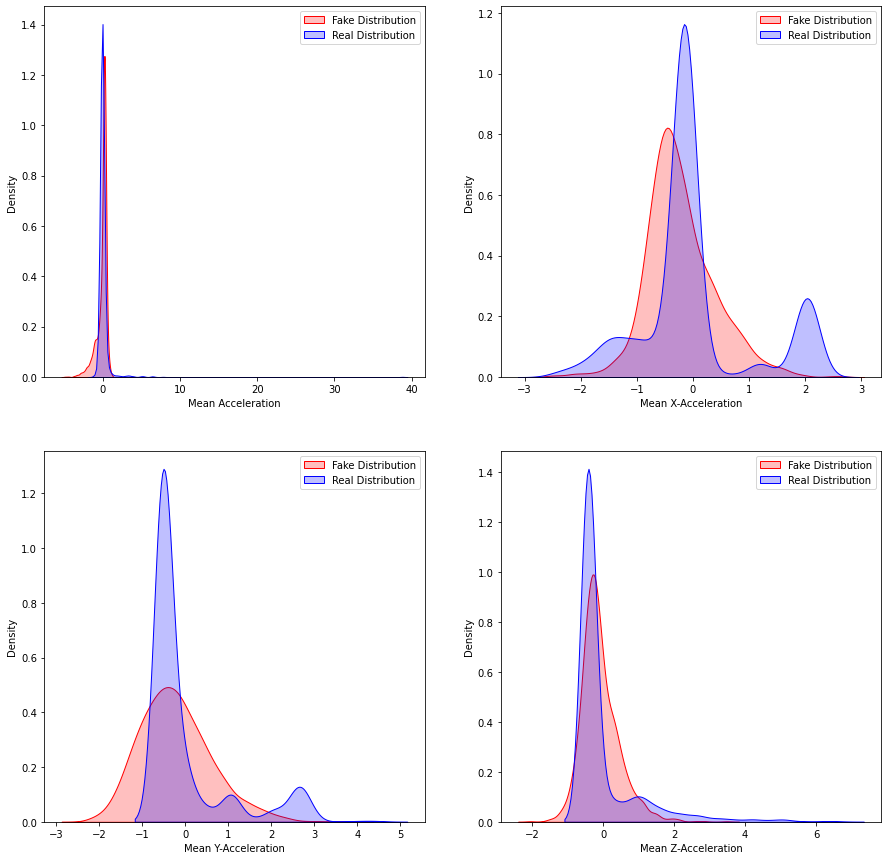

In [10]:
#Number of datum to visualize
sample_size = len(X)
reals = X[0:sample_size, :]
fakes = get_fake_samples(gen, sample_size, z_dim).detach()
density_curves(reals, fakes)

In [11]:
model_output = pd.read_csv('../model_outputs/1k_5_2_constant_GAN.csv')
model_output.head()

def plot_metrics(data, vanilla = True):
    if vanilla:
        sns.set(style = 'whitegrid', context = 'talk', palette = 'rainbow')
    
        plt.figure(figsize = (15, 15))
        subplot(2, 2, 1)
        sns.scatterplot(x = 'Epoch', y = 'FPR', data = data).set(xlim = (0, None))
        sns.despine()
        
        subplot(2, 2, 2)
        sns.scatterplot(x = 'Epoch', y = 'Recall', data = data).set(xlim = (0, None))
        sns.despine()
        
        subplot(2, 2, 3)
        sns.regplot(x = 'Epoch', y = 'Median Wasserstein', data = data, line_kws = {'color': 'orange'}).set(xlim = (0, None))
        sns.despine()
        
        subplot(2, 2, 4)
        sns.regplot(x = 'Epoch', y = 'Mean Wasserstein', data = data, line_kws = {'color': 'orange'}).set(xlim = (0, None))
        sns.despine()
        plt.show()
    else:
        sns.set(style = 'whitegrid', context = 'talk', palette = 'rainbow')
        plt.figure(figsize = (15, 8))
        
        subplot(1, 2, 1)
        sns.regplot(x = 'Epoch', y = 'Median Wasserstein', data = data, line_kws = {'color': 'orange'}).set(xlim = (0, None))
        sns.despine()
        
        subplot(1, 2, 2)
        sns.regplot(x = 'Epoch', y = 'Mean Wasserstein', data = data, line_kws = {'color': 'orange'}).set(xlim = (0, None))
        sns.despine()
        
        plt.show()

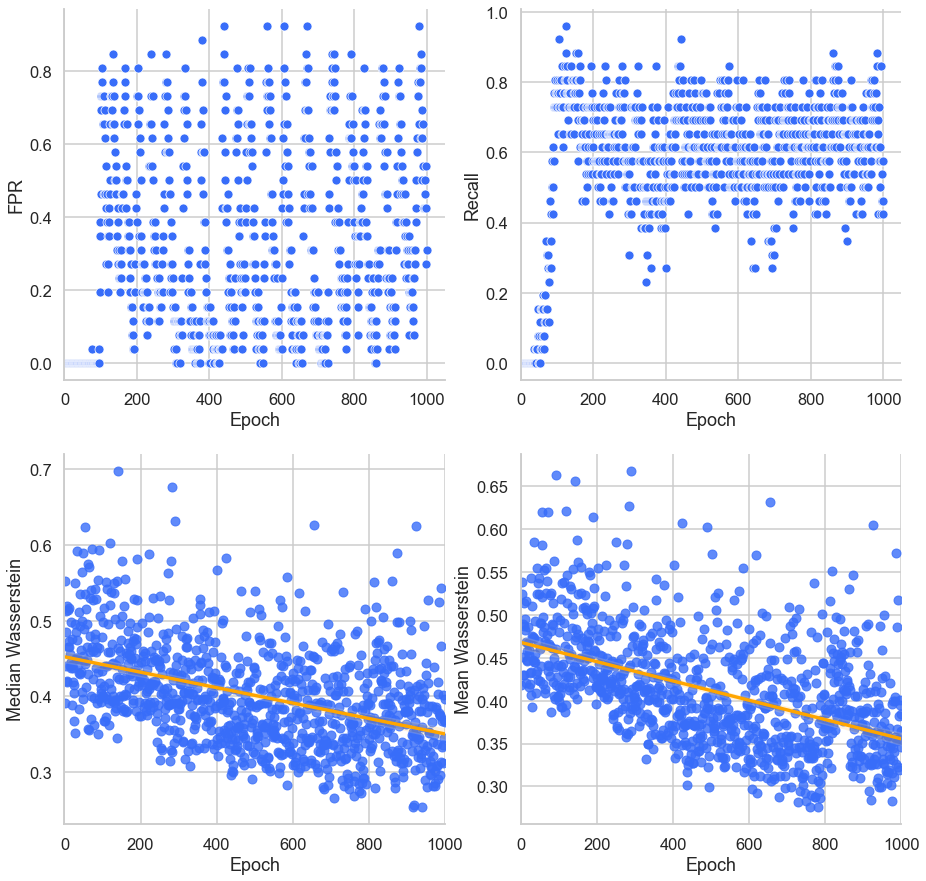

In [12]:
plot_metrics(model_output, True)

# Real/Fake Train Evaluation Metric

In [13]:
def generate_fake_real_dataset(gen, data, scaler):
    data = interpolation(data) #Interpolates entire dataframe
    not_sitting = data[data['label:SITTING'] == 0] #Only selects rows where sitting is 0
    real_features = not_sitting.iloc[:,1:27] #Selects only acceleration columns
    
    real_features = real_features.values #Converting to a numpy array
    real_features = scaler.transform(real_features) # These are all the scaled acceleration features for non-sitting real data
    real_features_size = real_features.shape[0] #Number of real samples
    y_label_notsitting = [0] * real_features_size #0 corresponds to the non-sitting class
    y_label_notsitting = np.asarray(y_label_notsitting).reshape(-1, 1) #Reshaping into a 2D column vector
    
    #Generating fake acceleration features for sitting data
    latent_vectors = get_noise(real_features_size, z_dim) #Generate the same number of fake sitting samples as real non-sitting samples
    fake_features = gen(latent_vectors).detach().numpy() #Generator already creates scaled features, so no scaling necessary
    y_label_sitting = [1] * real_features_size
    y_label_sitting = np.asarray(y_label_sitting).reshape(-1, 1)
    
    #Concatenating fake/real features and labels
    all_features = np.concatenate((real_features, fake_features), axis = 0) #Vertical concatenation
    all_labels = np.concatenate((y_label_notsitting, y_label_sitting), axis = 0).flatten() #Flatten 2D vector into 1D array for LogisticRegression
    
    #Splitting into train/test sets
    X_train, X_test, y_train, y_test = train_test_split(all_features, all_labels, test_size = 0.2, shuffle = True)
    return X_train, y_train, X_test, y_test

def generate_real_dataset(data, scaler):
    data = interpolation(data) #Interpolating the entire dataframe
    features = data.iloc[:,1:27] #Selecting only acceleration columns
    features = features.values #Converting to a numpy array
    features = scaler.transform(features) #Scaling all rows in the dataframe
    labels = data['label:SITTING'].values
    
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = 0.2, shuffle = True)
    return X_train, y_train, X_test, y_test

def train_test_real_fake(X_train, y_train, X_test, y_test):
    classifier = LogisticRegression(penalty = 'l2', C = 0.8)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    f1 = classifier_performance(y_pred, y_test)
    return f1

def train_test_real(X_train, y_train, X_test, y_test): 
    classifier = LogisticRegression(penalty = 'l2', C = 0.8)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    f1 = classifier_performance(y_pred, y_test)
    return f1

def classifier_performance(y_pred, y_test):
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    
    for k in range(len(y_pred)):
        #True positive
        if y_test[k] == 1 and y_pred[k] == 1:
            tp += 1
        #False Negative
        elif y_test[k] == 1 and y_pred[k] == 0:
            fn += 1
        #True Negative
        elif y_test[k] == 0 and y_pred[k] == 0:
            tn += 1
        elif y_test[k] == 0 and y_pred[k] == 1:
            fp += 1
        else:
            print("Error")
            exit()
            
    acc = (tp + tn)/(tp + tn + fp + fn)

    if tp + fp == 0:
        precision = 0
    else:
        precision = tp / (tp + fp)

    if tp + fn == 0:
        recall = 0
    else:
        recall = tp / (tp + fn)
    
    f1 = 2*(precision * recall / (precision + recall + 0.001))
    
    print(f'Precision: {precision:.3f} Recall: {recall:.3f} F-1 Score: {f1:.3f}')
    
    return acc, f1